# Описание проекта

**Цель** - проанализировать тарифы федерального оператора связи и проверить гипотезы на основе полученных данных.

# Задачи и исследования

1. Исследовние и обработка данных
  - исследуем данные
  - удалить дубликаты
  - обработать пропуски
  - исправим аномалии
  - заменим некоректные данные
  - приведем данные к нужным типам
  
2. Подготовка данных

  Посчитайте для каждого пользователя:
  
  - количество сделанных звонков и израсходованных минут разговора по месяцам
  - количество отправленных сообщений по месяцам
  - объем израсходованного интернет-трафика по месяцам
  - помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;  остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).
  
3. Проанализируем данные

  Описать поведение клиентов оператора из выборки
  
  - Сколько минут разговоров, сообщений и какой объем интернет-трафика требуется для каждого тарифа в месяц
  - Посчитайте среднее кол-во, дисперсию и стандартное отклонение
  - Постройте гистограммы
  - Опишите распределения
  
4. Проверим гипотезы
  - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
  - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
  
5. Выводы

## Исследовние и обработка данных 

Просмотрим данные и обработаем их.

In [1]:
import pandas as pd
from functools import reduce
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from datetime import datetime
from scipy import stats as st

users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [2]:
#начнем со столбца "users"
users.head(15)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Много пропусков в churn_date, hurn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Можем не трогать этот столбец.

In [3]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [4]:
print(users.shape[0])
print(users['user_id'].count())
print(users.duplicated().sum())

500
500
0


Здесь мы видим, что кол-во уникальных пользователей совпадает. Дубликаты отсуствуют

In [5]:
#приведем даты в порядок
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


In [7]:
# теперь также проверим столбец calls 
calls.head(15)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [8]:
print(calls.shape[0])
print(calls['user_id'].count())
print(calls.duplicated().sum())

202607
202607
0


In [9]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [10]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [11]:
# приведем даты в порядок
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In [12]:
# приведем к нужному типу
calls['id'] = calls['id'].astype('int')

In [13]:
#округлим продолжительность звонков до целых чисел, т.к наш оператор так и делает
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
calls.head(10)

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,3,1000
3,10003,2018-09-21,14,1000
4,10004,2018-12-15,6,1000
5,10005,2018-11-02,0,1000
6,10006,2018-10-18,0,1000
7,10007,2018-08-22,19,1000
8,10008,2018-09-15,19,1000
9,10009,2018-08-15,0,1000


Мы можем наблюдать много 0, однако в описании проекта сказано: "Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять." Прэтому ничего с ними делать не будем.

Со всем остальным здесь проблем нет.

In [14]:
# перейдем к столбцу messages
messages.head(15)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [15]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


нужно привести "id" и "message_date" к нужному типу и формату

In [16]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [17]:
messages['id'] = messages['id'].astype('int')

In [18]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  int64         
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


В остальном все нормально

In [19]:
# теперь перейлем к столбцу internet
internet.head(15)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [20]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [21]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


приведем столбцы 'id' и 'session_date' к нужному формату и типу

In [22]:
internet['id'] = internet['id'].astype('int')

In [23]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [24]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  int64         
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 5.7 MB


In [25]:
# теперь округлим весь трафик до мегабайта
#internet['mb_used'] = internet['mb_used'].apply(np.ceil)
#internet.head(15)

In [26]:
# переведем мб в гб в таблице трафика для дальнейшего подсчета
internet['gb_used'] = (internet['mb_used'] / 1024)
internet.head(15)

,Unnamed: 0,id,mb_used,session_date,user_id,gb_used
0,0,10000,112.95,2018-11-25,1000,0.110303
1,1,10001,1052.81,2018-09-07,1000,1.028135
2,2,10002,1197.26,2018-06-25,1000,1.169199
3,3,10003,550.27,2018-08-22,1000,0.537373
4,4,10004,302.56,2018-09-24,1000,0.295469
5,5,10005,399.97,2018-10-02,1000,0.390596
6,6,10006,540.08,2018-09-07,1000,0.527422
7,7,10007,415.70,2018-07-11,1000,0.405957
8,8,10008,505.40,2018-10-08,1000,0.493555
9,9,10009,345.54,2018-09-03,1000,0.337441


Есть пользователи с нулевым графиком. Посмотрим как их много:

<AxesSubplot:ylabel='Frequency'>

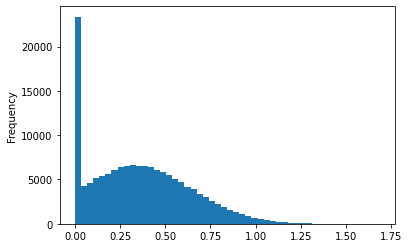

In [27]:
internet['gb_used'].plot(kind='hist', bins=50)

In [28]:
internet.query('gb_used == 0')

,Unnamed: 0,id,mb_used,session_date,user_id,gb_used
11,11,100011,0.0,2018-08-28,1000,0.0
38,38,100038,0.0,2018-11-27,1000,0.0
46,46,100046,0.0,2018-06-30,1000,0.0
67,67,100067,0.0,2018-06-16,1000,0.0
72,72,100072,0.0,2018-06-15,1000,0.0
...,...,...,...,...,...,...
149380,149380,1499141,0.0,2018-12-11,1499,0.0
149381,149381,1499142,0.0,2018-11-01,1499,0.0
149383,149383,1499144,0.0,2018-11-27,1499,0.0
149386,149386,1499147,0.0,2018-10-21,1499,0.0


Таких строк слишком ного, будет лучше их исключить.

<AxesSubplot:ylabel='Frequency'>

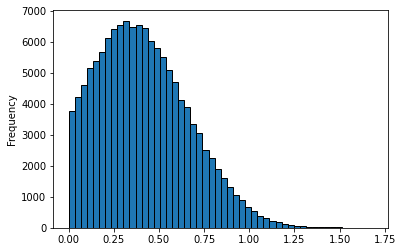

In [29]:
internet['gb_used'] = internet['gb_used'].replace(0, np.NaN)
internet = internet.dropna()
# и сразу проверим
internet['gb_used'].plot(kind='hist', ec='black', bins=50)

In [30]:
# проверим последний столбец tariffs
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Здесь все хорошо.

## Подготовка данных

Посчитаем для каждого пользователя:
  - количество сделанных звонков и израсходованных минут разговора по месяцам
  - количество отправленных сообщений по месяцам
  - объем израсходованного интернет-трафика по месяцам
  - помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;  остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [31]:
# добавим столбец 'month' к звонкам, интернету и смс
calls['month'] = calls['call_date'].dt.month_name()
messages['month'] = pd.to_datetime(messages['message_date']).dt.month_name()
internet['month'] = pd.to_datetime(internet['session_date']).dt.month_name()
calls.head()

,id,call_date,duration,user_id,month
0,10000,2018-07-25,0,1000,July
1,10001,2018-08-17,0,1000,August
2,10002,2018-06-11,3,1000,June
3,10003,2018-09-21,14,1000,September
4,10004,2018-12-15,6,1000,December


In [32]:
messages.head()

,id,message_date,user_id,month
0,10000,2018-06-27,1000,June
1,10001,2018-10-08,1000,October
2,10002,2018-08-04,1000,August
3,10003,2018-06-16,1000,June
4,10004,2018-12-05,1000,December


In [33]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,gb_used,month
0,0,10000,112.95,2018-11-25,1000,0.110303,November
1,1,10001,1052.81,2018-09-07,1000,1.028135,September
2,2,10002,1197.26,2018-06-25,1000,1.169199,June
3,3,10003,550.27,2018-08-22,1000,0.537373,August
4,4,10004,302.56,2018-09-24,1000,0.295469,September


In [34]:
# посчитаем кол-во сделанных звонков и израсходованных минут разговора по месяцам
calls_grouped = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count'])
calls_grouped.reset_index()
calls_grouped.columns = ['calls_duration', 'calls_amount']

In [35]:
# посчитаем кол-во объема израсходованного интернет-трафика по месяцам
internet_grouped = internet.pivot_table(index=['user_id', 'month'], values='gb_used', aggfunc=['sum'])
internet_grouped.columns = ['gb_used']
internet_grouped.reset_index()

,user_id,month,gb_used
0,1000,August,13.726494
1,1000,December,9.587510
2,1000,July,13.675430
3,1000,June,22.689229
4,1000,May,2.200674
...,...,...,...
3196,1498,September,21.615635
3197,1499,December,12.749590
3198,1499,November,17.542295
3199,1499,October,17.371592


In [36]:
# посчитаем кол-во отправленных сообщений по месяцам
messages_grouped = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_grouped.reset_index()
messages_grouped.columns=['messages_amount']

In [37]:
# теперь все данные соеденим
#data = calls_grouped.merge(messages_grouped, on=['user_id','month'], how='outer')
#data = data.merge(internet_grouped, on=['user_id','month'], how = 'outer')

In [38]:
#calls_internet_merged = calls_grouped.merge(internet_grouped, on=['user_id', 'month'], how='left')
#telecom_data = calls_internet_merged.merge(messages_grouped, on=['user_id', 'month'], how='left')
#telecom_data_pvt = telecom_data.pivot_table(index=['user_id', 'month'])
#telecom_data_pvt=telecom_data_pvt.reset_index()

In [39]:
data_frame = [calls_grouped, internet_grouped, messages_grouped]
data = reduce(lambda  left,right: pd.merge(left,right,on=['user_id', 'month'],
                                            how='outer'), data_frame).fillna(0)

In [40]:
#data = telecom_data_pvt.merge(users, on='user_id', how='right').pivot_table(
    #index=['user_id', 'first_name', 'last_name', 'age', 'city', 'tariff', 'reg_date', 'churn_date', 'month'])
#data = data.reset_index()

In [41]:
# проверим как все соединилось
data.head(10)

calls_duration  calls_amount    gb_used  messages_amount
user_id month                                                              
1000    August              408.0          52.0  13.726494             81.0
        December            333.0          46.0   9.587510             70.0
        July                340.0          47.0  13.675430             75.0
        June                172.0          43.0  22.689229             60.0
        May                 159.0          22.0   2.200674             22.0
        November            338.0          43.0  14.410615             58.0
        October             350.0          57.0  14.357900             73.0
        September           466.0          58.0  14.227451             57.0
1001    December            414.0          63.0  13.707676              0.0
        November            430.0          59.0  17.997402              0.0

In [42]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [43]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

In [44]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [45]:
data.loc[data['calls_duration'].isna(), 'calls_duration'] = 0
data.loc[data['messages_amount'].isna(), 'messages_amount'] = 0
data.loc[data['gb_used'].isna(), 'gb_used'] = 0

In [46]:
for user in data.index:
    data.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']
data.head(10)

calls_duration  calls_amount    gb_used  messages_amount  \
user_id month                                                                 
1000    August              408.0          52.0  13.726494             81.0   
        December            333.0          46.0   9.587510             70.0   
        July                340.0          47.0  13.675430             75.0   
        June                172.0          43.0  22.689229             60.0   
        May                 159.0          22.0   2.200674             22.0   
        November            338.0          43.0  14.410615             58.0   
        October             350.0          57.0  14.357900             73.0   
        September           466.0          58.0  14.227451             57.0   
1001    December            414.0          63.0  13.707676              0.0   
        November            430.0          59.0  17.997402              0.0   

                  tariff  
user_id month             
1000    August     ultra  
        December   ultra  
        July       ultra  
        June       ultra  
        May        ultra  
        November   ultra  
        October    ultra  
        September  ultra  
1001    December   smart  
        November   smart

Проверим датафрейм на выбивающиеся данные

In [47]:
# проверим на дубликаты
data.duplicated().sum()

0

Все впорядке, можем работать с датафреймом дальше. Теперь выполним следующее условие: посчитаем помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

В таблице data увидим помесячно кол-во и длительность звонков, кол-во сообщений и объем использованного трафика для каждого пользователя

In [48]:
# округлим гб до целых чисел
data['gb_used'] = data['gb_used'].apply(np.ceil)

In [49]:
def revenue(row):
    if row['tariff'] == 'smart':
        if row['messages_amount'] > 50:
            messages_extra = (row['messages_amount'] - 50)*3
        else:
            messages_extra = 0
        if row['calls_duration'] > 500:
            calls_extra = (row['calls_duration'] - 500)*3
        else:
            calls_extra = 0
        if row['gb_used'] > 15:
            gb_extra = (row['gb_used'] - 15)*200
        else:
            gb_extra = 0
        total_cost = messages_extra + calls_extra + gb_extra + 550
        
    if row['tariff'] == 'ultra':
        if row['messages_amount'] > 1000:
            messages_extra = (row['messages_amount'] - 1000)*1
        else:
            messages_extra = 0
        if row['calls_duration'] > 3000:
            calls_extra = (row['calls_duration'] - 3000)*1
        else:
            calls_extra = 0
        if row['gb_used'] > 30:
            gb_extra = (row['gb_used'] - 30)*150
        else:
            gb_extra = 0
        total_cost = messages_extra + calls_extra + gb_extra + 1950
    return total_cost


In [50]:
data['total_cost'] = data.apply(revenue, axis=1)
data.head(10)

calls_duration  calls_amount  gb_used  messages_amount  \
user_id month                                                               
1000    August              408.0          52.0     14.0             81.0   
        December            333.0          46.0     10.0             70.0   
        July                340.0          47.0     14.0             75.0   
        June                172.0          43.0     23.0             60.0   
        May                 159.0          22.0      3.0             22.0   
        November            338.0          43.0     15.0             58.0   
        October             350.0          57.0     15.0             73.0   
        September           466.0          58.0     15.0             57.0   
1001    December            414.0          63.0     14.0              0.0   
        November            430.0          59.0     18.0              0.0   

                  tariff  total_cost  
user_id month                         
1000    August     ultra      1950.0  
        December   ultra      1950.0  
        July       ultra      1950.0  
        June       ultra      1950.0  
        May        ultra      1950.0  
        November   ultra      1950.0  
        October    ultra      1950.0  
        September  ultra      1950.0  
1001    December   smart       550.0  
        November   smart      1150.0

In [51]:
data = data.merge(users, on=['user_id', 'tariff'], how = 'outer')
data = data.merge(tariffs, on='tariff', how = 'outer')
data.head()

,user_id,calls_duration,calls_amount,gb_used,messages_amount,tariff,total_cost,age,churn_date,city,first_name,last_name,reg_date,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,408.0,52.0,14.0,81.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
1,1000,333.0,46.0,10.0,70.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
2,1000,340.0,47.0,14.0,75.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
3,1000,172.0,43.0,23.0,60.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
4,1000,159.0,22.0,3.0,22.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1


На этапе предобработки данных мы сделали следующее:
 - изменили типы данных
 - округли данные в большую сторону до целых чисел( как было сказано в описании проекта)
 - не трогали пропущенные значения в столбце churn_date, т.к это значит, что пользователь не прекращал пользоваться тарифом
 - не трогали 0, т.к это обозначение непринятых звонков (о чем тоже говорилось в задании)
 - были обработаны и переведены данные по интернету (мб в гб)
 -  был посчитан объем израсходованного интернет-трафика по месяцам
 - вычислили помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Теперь можем переходить к анализу данных.

## Анализ данных

  - Сколько минут разговоров, сообщений и какой объем интернет-трафика требуется для каждого тарифа в месяц
  - Посчитайте среднее кол-во, дисперсию и стандартное отклонение
  - Постройте гистограммы
  - Опишите распределения

Выясним, сколько минут разговора, трафика и сообщений в среднем в месяц требуется пользователям каждого тарифа. Создадим сводную таблицу, сгруппировав данные по пользователям и используя функцию для нахождения медианы.

In [52]:
data.head()

,user_id,calls_duration,calls_amount,gb_used,messages_amount,tariff,total_cost,age,churn_date,city,first_name,last_name,reg_date,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,408.0,52.0,14.0,81.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
1,1000,333.0,46.0,10.0,70.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
2,1000,340.0,47.0,14.0,75.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
3,1000,172.0,43.0,23.0,60.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
4,1000,159.0,22.0,3.0,22.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1


In [53]:
medians_per_month = data.pivot_table(index='user_id', values=['calls_duration', 'gb_used', 'messages_amount', 'total_cost'], aggfunc='median')
for user_id in users['user_id']:
    medians_per_month.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
medians_per_month.sample(10)

,calls_duration,gb_used,messages_amount,total_cost,tariff
user_id,,,,,
1340,450.5,17.5,11.0,1050.0,smart
1017,377.5,17.5,0.0,1050.0,smart
1157,419.0,20.0,0.0,1670.0,smart
1470,492.0,18.0,11.0,1150.0,smart
1093,825.0,18.0,72.0,2275.0,smart
1357,336.0,19.0,41.5,1350.0,smart
1380,711.5,35.0,26.0,2700.0,ultra
1286,393.0,20.0,40.0,2935.5,smart
1488,423.5,15.5,92.0,876.0,smart


Здесь мы взяли 10 случайных строк и видим, что многие могут вообще не пользоваться какими-то услугами своего тарифа.

Теперь посчитаем среднее кол-во, дисперсию и стандартное отклонение для более простого подсчета и анализа создадим общую таблицу.

In [54]:
analiz_tariff = data.pivot_table(index=['tariff'], values=['calls_duration', 'gb_used', 'messages_amount'], 
                    aggfunc={'calls_duration': [np.mean, np.median, np.var, np.std], 
                             'gb_used': [np.mean, np.median, np.var, np.std], 
                             'messages_amount': [np.mean, np.median, np.var, np.std]})
analiz_tariff.applymap("{:.1f}".format) # пришлось округлить

calls_duration                         gb_used                    \
                 mean median    std       var    mean median  std   var   
tariff                                                                    
smart           417.9  422.0  190.3   36219.3    16.3   17.0  5.7  33.0   
ultra           526.6  518.0  317.6  100873.6    19.5   19.0  9.9  97.1   

       messages_amount                       
                  mean median   std     var  
tariff                                       
smart             33.4   28.0  28.2   796.8  
ultra             49.4   38.0  47.8  2285.3

Из этих данных сделаем следующие выводы:
 - в среднем по тарифу ultra разговаривают 518 минуты, а вот по smart 422 минут.
 - интернет также больше расходуется у тарифа ultra (19гб), когда как у smart 17 гб
 - смс у ultra расходуется  38, а у smart 28
 - дисперсия у ultra больше, что говорит о большем размахе значений

В итоге мы видим, что пользоатели оператором ultra пользуются услугами больше, чем у smart, при этом обычно пользователи не превышают пакет тарифа. Когда как пользователям smart приходится докупать доп. услуги к своему ежемесячному тарифу(интернет 1 гб).

Теперь построим гистограммы

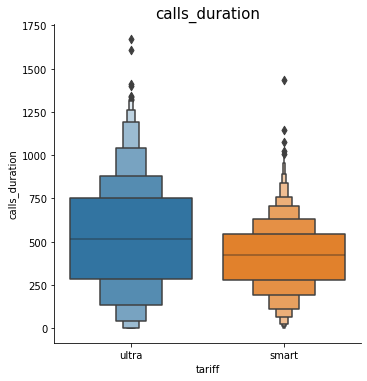

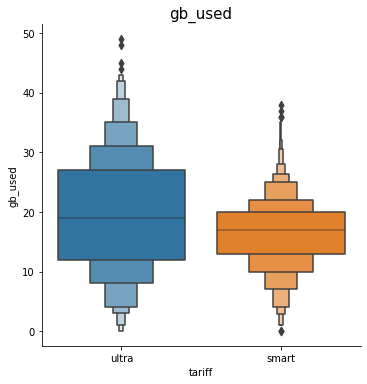

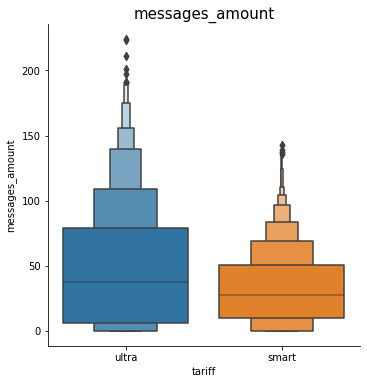

In [55]:
for column in ['calls_duration', 'gb_used', 'messages_amount']:
    sns.catplot(x='tariff', y=column, data=data, kind='boxen')
    plt.title(column, fontsize=15) 

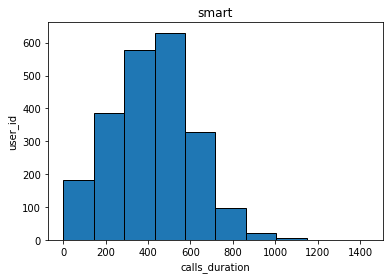

In [56]:
data[data['tariff'] == 'smart']['calls_duration'].plot(kind='hist', ec='black', bins=10)
plt.title("smart")
plt.xlabel("calls_duration")
plt.ylabel("user_id")
plt.show() 

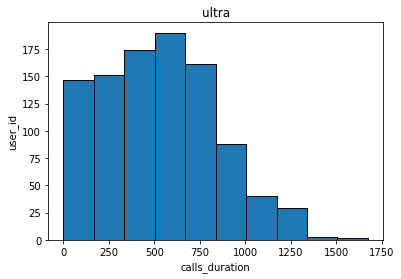

In [57]:
data[data['tariff'] == 'ultra']['calls_duration'].plot(kind='hist', ec='black', bins=10)
plt.title("ultra")
plt.xlabel("calls_duration")
plt.ylabel("user_id")
plt.show() 

Чтож, тут мы видим, что по тарифу smart пользователи почти полностью израсходывают свой тариф, когда как у тарифа ultra остается еще остаток.

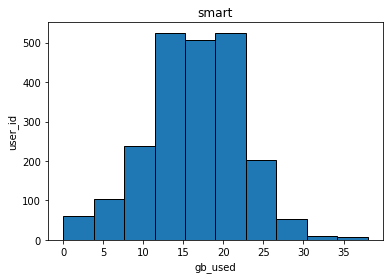

In [58]:
data[data['tariff'] == 'smart']['gb_used'].plot(kind='hist', ec='black', bins=10)
plt.title("smart")
plt.xlabel("gb_used")
plt.ylabel("user_id")
plt.show() 

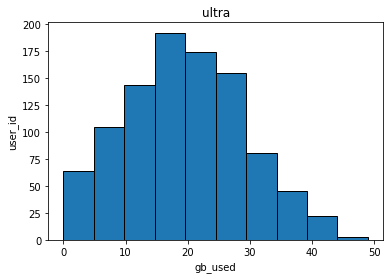

In [59]:
data[data['tariff'] == 'ultra']['gb_used'].plot(kind='hist', ec='black', bins=10)
plt.title("ultra")
plt.xlabel("gb_used")
plt.ylabel("user_id")
plt.show() 

В тарифе ultra больше разброс, как уже отмечалось выше. И картина здесь такая же, как и у звонков - у тарифа ultra остается запас интернета, а у другого - нет.

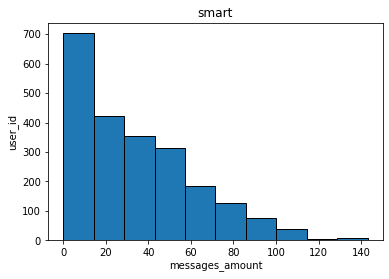

In [60]:
data[data['tariff'] == 'smart']['messages_amount'].plot(kind='hist', ec='black', bins=10)
plt.title("smart")
plt.xlabel("messages_amount")
plt.ylabel("user_id")
plt.show() 

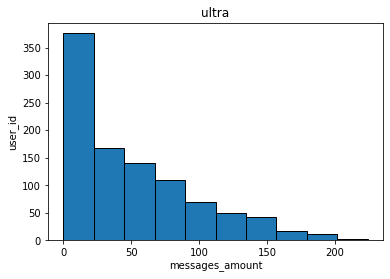

In [61]:
data[data['tariff'] == 'ultra']['messages_amount'].plot(kind='hist', ec='black', bins=10)
plt.title("ultra")
plt.xlabel("messages_amount")
plt.ylabel("user_id")
plt.show() 

В целом мы видим, что по тарифу ultra смс пользуются больше, но опять же это скорее из-за разброса. 

In [62]:
data.pivot_table(index='tariff', values='total_cost', aggfunc='sum')

,total_cost
tariff,
smart,2875351.0
ultra,2039100.0


Подводя еще раз итог, мы видим, что тариф ultra как абонентам, так и компании. Несмотря на то, что пользователей у тарифа ultra меньше, но сам тариф горазда дороже. С другой стороны, из-за того, что у тарифа  smart пакета услуг не хватает к концу месяца, и по логике это дожно стимулировать покупку доп.пакета услуг, но на деле этим пользуются не многие пользватели. 

## Проверка гипотез 

  - средняя выручка пользователей тарифов Ultra и Smart различаются
  - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Проверим гипотезу о том, что  средняя выручка пользователей тарифов Ultra и Smart различаются. Возьмем Н0 - средняя выручка пользователей тарифов Ultra и Smart равная, а Н1- средняя выручка пользователей тарифов Ultra и Smart различаются. За уровень значимости возьмем 0,1%.

In [63]:
data.head(15)

,user_id,calls_duration,calls_amount,gb_used,messages_amount,tariff,total_cost,age,churn_date,city,first_name,last_name,reg_date,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,408.0,52.0,14.0,81.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
1,1000,333.0,46.0,10.0,70.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
2,1000,340.0,47.0,14.0,75.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
3,1000,172.0,43.0,23.0,60.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
4,1000,159.0,22.0,3.0,22.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
5,1000,338.0,43.0,15.0,58.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
6,1000,350.0,57.0,15.0,73.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
7,1000,466.0,58.0,15.0,57.0,ultra,1950.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,1000,30720,3000,1950,150,1,1
8,1003,380.0,55.0,9.0,37.0,ultra,1950.0,23,NaN,Москва,Белла,Белякова,2018-08-17,1000,30720,3000,1950,150,1,1
9,1003,802.0,108.0,10.0,75.0,ultra,1950.0,23,NaN,Москва,Белла,Белякова,2018-08-17,1000,30720,3000,1950,150,1,1


In [64]:
# для упрощения счета создадим новых два датафрейма для каждого из тарифов
ultra = data.query('tariff=="ultra"')['total_cost']
smart = data.query('tariff=="smart"')['total_cost']

In [65]:
# Выясним, как различаются дисперсии тарифоф ultra и smart
print(ultra.var(ddof=1))
print(smart.var(ddof=1))

141516.7450786183
669785.7080064242


Рассмотрим два этих датафрейма как две независмые выборки (будем использовать ttest_ind), дисперсии для выборок сильно отличаются, то небоходимо учесть это в функции, добавив аргумент equal_var=False.

In [66]:
alpha = .001

gip_1 = st.ttest_ind(smart, ultra, equal_var=False, nan_policy='omit') 
print('p-значение:', gip_1.pvalue)

if (gip_1.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


Получается средние выручки не равны. Посмотрим средние показатели наглядно.

In [67]:
data.pivot_table(index='tariff', values='total_cost', aggfunc='mean')

,total_cost
tariff,
smart,1289.973531
ultra,2070.152284


В итоге мы видим, что средняя выручка действительно отличается почти в два раза. А это значит, что с большой вероятностью  можно утверждать, что средняя выручка пользователя тарифа Smart и тарифа Ultra отличаются.

Теперь проверим вторую гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

За Н0 мы возмем утверждение: средняя выручка от пользователей из г. Москва равно средней выручке пользователей других городов.
Н1: средняя выручка от пользователей из г. Москва не равна средней выручке пользователей других городов. Значимость возмем такую же, как и в прошлый раз.


In [68]:
# идем по тому же сценарию и задаем два новых датафрейма
moscow = data.query('city == "Москва"')['total_cost']
others = data.query('city != "Москва"')['total_cost']

In [69]:
print(moscow.var(ddof=1))
print(others.var(ddof=1))

565636.467011886
654137.6285218114


Здесь мы видим, что дисперсия почти одинаковая, но все же различаются, поэтому воспользуемся аналогичной системой.

In [70]:
alpha = .01

gip_2 = st.ttest_ind( moscow, others, equal_var=False, nan_policy='omit')

print('p-значение:', gip_2.pvalue)

if (gip_2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Чтож, здесь получается, что если бы решили сравнить Москву с другими городами, то получилось бы, что выручки примерно равны.

In [71]:
# также попробуем рассмотреть средние выручки
cities = data.copy()
cities.loc[cities.loc[:,'city'] != 'Москва', 'city'] = 'Другой город'
cities.pivot_table(index='city', values='total_cost', aggfunc='mean')

,total_cost
city,
Другой город,1524.936227
Москва,1546.713584


Что и требовалось доказать

В результате, мы проверили две гипотезы:
  - средняя выручка пользователей тарифов Ultra и Smart различаются
  - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
За значимость мы взяли 0.01%. Их альтернативными утверждениями стали, что выручки в обоях случаях равны.  

Получилось:
  - средняя выручка пользователя тарифа Smart и тарифа Ultra отличаются
  - средняя выручка от пользователей из г. Москва  равно средней выручке пользователей других городов

## Выводы 

Подводя итоги работы, мы можем отметить следующее:были изучены данные о клиентах, информацию о датах и продолжительности звонков, отправленных сообщениях, интернет сессиях и использованном трафике, а так же общую информацию о тарифах компании; эти данные были обработаны для более удобной работы с ними; некоторые данные были не тронуты, т.к в описании проекта были уточнения, касаемые их.

 На этапе обработки мы сделали следующие выводы:
 - в среднем по тарифу ultra разговаривают 518 минуты, а вот по smart 422 минут.
 - интернет также больше расходуется у тарифа ultra (19гб), когда как у smart 17 гб
 - смс у ultra расходуется  38, а у smart 28
 - дисперсия у ultra больше, что говорит о большем размахе значений
 
 
Дальнейшая постройка графиков подтвердило, что тариф ultra выгоден во всех позициях. Пользователи данного тарифа не должны переживать к концу месяца, что из пакет услуг закончится и им придется покупать что-то дополнительно. По выручке данный тариф также более выгоден и для компании (smart - 121285.0,  ultra - 160500.0).


Дальше нами были проверены две гипотезы:
  - средняя выручка пользователей тарифов Ultra и Smart различаются
  - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
За значимость мы взяли 0.01%. Их альтернативными утверждениями стали, что выручки в обоях случаях равны.  

В итоге наши гипотезы имеют вот такой результат:
  - средняя выручка пользователя тарифа Smart и тарифа Ultra отличаются
  - средняя выручка от пользователей из г. Москва  равно средней выручке пользователей других городов
  
В целом, тариф Ultra действительно выгоден как для компании, так и для абонентов. В целом, стоит простимулировать переход пользователей тарифом Smart на тариф Ultra.